# YES, IT IS

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots, mcmc

relmod = reloader(randomized_ir, utils, plots, mcmc)

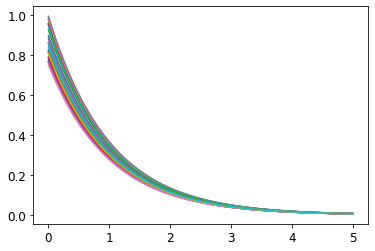

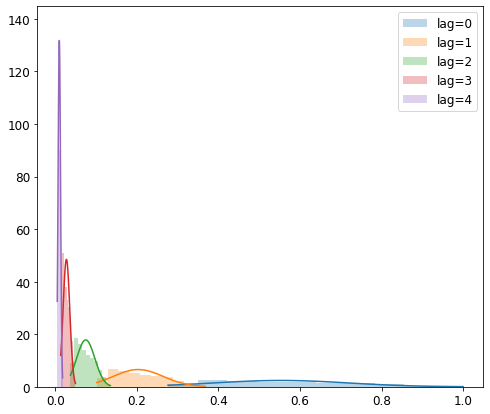

In [3]:
from random import random

L_true = 5
ir_x = np.linspace(0, L_true, int(L_true * 100))
ir_y = np.exp(- ir_x)
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.75 + random() * 0.25)
rir.plot_realizations(30)

L = rir.L
N = 50
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10 ** 5)
rireff.plot_samples()

In [4]:
n_vec_mean = 15
n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
s_vec = rir.convolve_with_n_vec(n_vec)

In [5]:
correlated_ll = rireff.get_loglikelihood_mvn(s_vec)
uncorrelated_ll = rireff.get_loglikelihood_uncorrelated_mvn(s_vec)
old_uncorrelated_ll = rireff.get_loglikelihood_independent_normdist(s_vec)

old_uncorrelated_ll(n_vec)

-47.91789395761602

In [7]:
# generating evaluation points for likelihood around true n_vec

n_evaluation_points = 1000
evaluation_pts = mcmc.starting_points_from_estimation(n_vec, n_walkers=n_evaluation_points, strategy='around_estimation')

In [8]:
@utils.timer(args_formatter=lambda l, p, n: n + f', {p.shape[0]} points')
def evaluate_loglike(loglike, points, name):
    results = []
    for p in points:
        results.append(loglike(p))  # converting loglike back to regular PDF for comparison
    return np.array(results)

In [9]:
corr_result = evaluate_loglike(correlated_ll, evaluation_pts, 'Full MVN')
uncorr_result = evaluate_loglike(uncorrelated_ll, evaluation_pts, 'Uncorrelated naive MVN')
old_uncorr_result = evaluate_loglike(old_uncorrelated_ll, evaluation_pts, 'Old uncorrelated MVN')

evaluate_loglike(Full MVN, 1000 points) took 0.737 seconds to complete.
evaluate_loglike(Uncorrelated naive MVN, 1000 points) took 0.481 seconds to complete.
evaluate_loglike(Old uncorrelated MVN, 1000 points) took 0.208 seconds to complete.


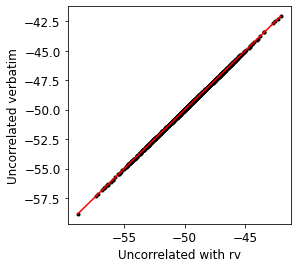

In [10]:
f, a = plots.plot_data_similarity_test(uncorr_result, old_uncorr_result, 'Uncorrelated with rv', 'Uncorrelated verbatim')

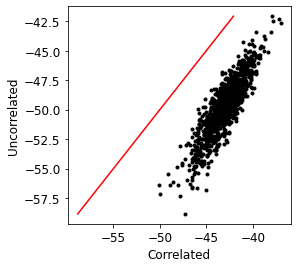

In [11]:
f, a = plots.plot_data_similarity_test(corr_result, uncorr_result, 'Correlated', 'Uncorrelated')

## Промежуточный результат

1. Быстрая функция корректна -- совпадает с вычислением с помощью `multivariate_normal`, но быстрее. Особенно быстрее получится при внесении ошибок!
2. Внесение корреляций систематически сдвигает функцию правдоподобия вниз -- как и ожидалось -- и тем сильнее, чем она меньше, то есть происходит занижение хвостов. Тем не менее, общий тренд выглядит нормально, и можно использовать быструю функцию правдоподобия без корреляций для получения изначальной выборки и сокращения периода burn-in, а затем уже переключаться на полную функцию правдоподобия и считать её в течении ~5 времён корреляции